# Removing Trends - Lab

## Introduction

In this lab, you'll practice your detrending skills!

## Objectives

You will be able to:
* Learn how to remove trends and seasonality
* Use a log transformation to minimize non-stationarity
* Use rolling means to reduce non-stationarity
* Use differencing to reduce non-stationarity

## Detrending the Airpassenger data

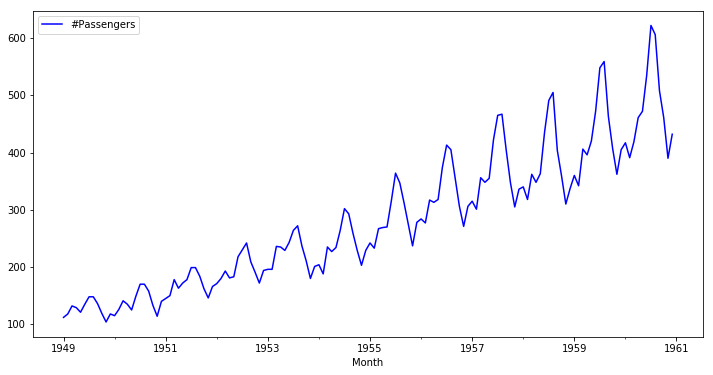

In [2]:
# Import necessary libraries
import pandas as pd
import datetime
from pandas import Series
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Import passengers.csv and set it as a time-series object. Plot the TS
data = pd.read_csv('passengers.csv')
ts = data.set_index('Month')
ts.index = pd.to_datetime(ts.index)
ts.plot(figsize=(12,6), color='b')



## Create a stationarity check

At this stage, we can use the code from previous labs to create a function `stationarity_check(ts)` that takes in a time series object and performs stationarity checks including rolling statistics and the Dickey Fuller test. 

We want the output of the function to:
- Plot the original time series along with the rolling mean and rolling standard deviation in one plot
- Output the results of the Dickey-Fuller test

In [3]:
# Create a function to check for the stationarity of a given timeseries using rolling stats and DF test
# Collect and package the code from previous lab
def stationarity_check(TS):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    rolmean = TS.rolling(window = 8, center = False).mean()
    rolstd = TS.rolling(window = 8, center = False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS['#Passengers']) # change the passengers column as required 
    
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print ('Results of Dickey-Fuller Test:')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    return None



Use your newly created function on the airpassenger data set.

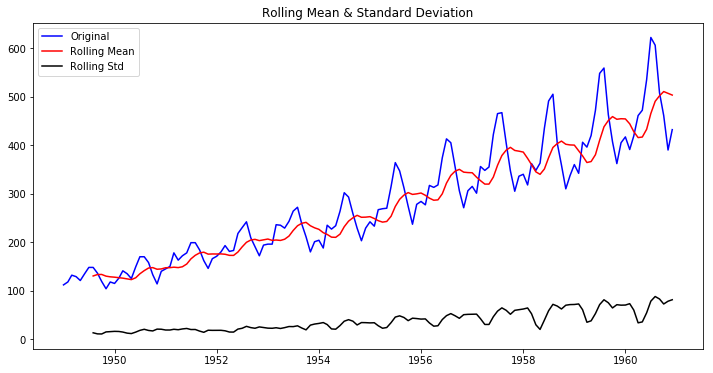

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [4]:
stationarity_check(ts)

## Perform a log() and sqrt() transform

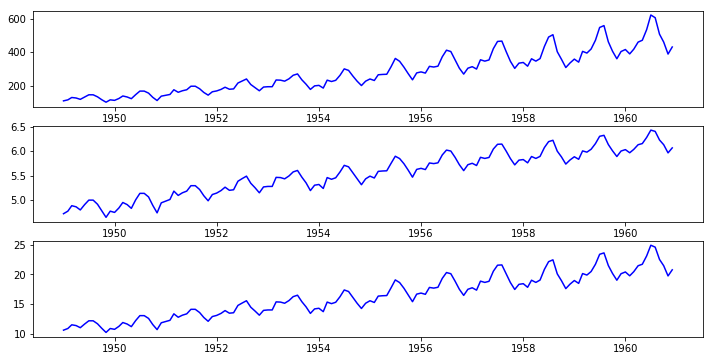

In [5]:
# Log transform timeseries and compare with original to check the effect
ts_log = np.log(ts)
ts_sqrt = np.sqrt(ts)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,6))
ax1.plot(ts, color='b')
ax2.plot(ts_log, color='b')
ax3.plot(ts_sqrt, color='b')



moving forward, let's keep working with the log transformed data before subtracting rolling mean, differencing, etc.

## Subtracting the rolling mean

Create a rolling mean using your log transformed time series, with a time window of 7. Plot the log-transformed time series and the rolling mean together.

Text(0.5, 1.0, 'Rolling Mean')

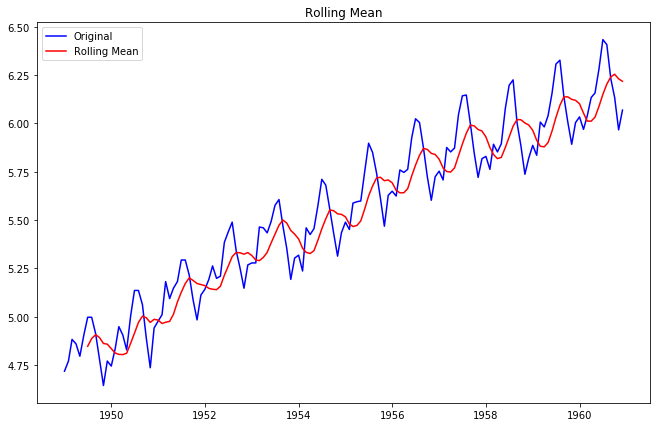

In [6]:
# your code here
r_mean = ts_log.rolling(window=7).mean()
fig, ax = plt.subplots(figsize=(11,7))
orig = plt.plot(np.log(ts), color='b', label='Original')
mean = plt.plot(r_mean, color='r', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling Mean')

Now, subtract the rolling mean from the time series, look at the 10 first elements of the result and plot the result.

In [7]:
# Subtract the moving average from the original data and check head for Nans
difference = np.log(ts) - r_mean
difference.head()


,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN


In [8]:
# Drop the NaN values from timeseries calculated above
difference.dropna(inplace=True)

Text(0.5, 1.0, 'Passengers Minus Rolling Mean')

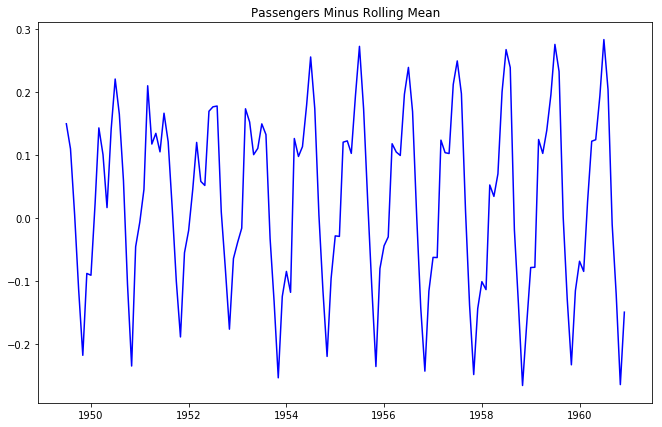

In [9]:
# Plot the result
fig, ax = plt.subplots(figsize=(11,7))
ax.plot(difference, color='b', label='Passengers - Rolling Mean')
plt.title('Passengers Minus Rolling Mean')

Finally, use your function `check_stationarity` to see if this series is considered stationary!

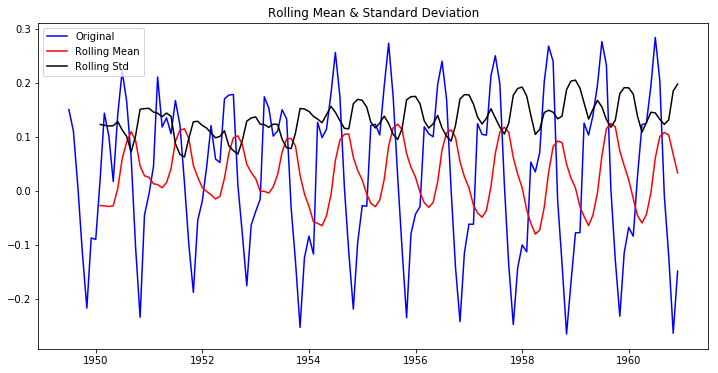

Results of Dickey-Fuller Test:
Test Statistic                  -2.348027
p-value                          0.156946
#Lags Used                      14.000000
Number of Observations Used    123.000000
Critical Value (1%)             -3.484667
Critical Value (5%)             -2.885340
Critical Value (10%)            -2.579463
dtype: float64


In [10]:
stationarity_check(difference)

### Based on the visuals and on the Dickey-Fuller test, what do you conclude?


Not stationary, p-value at .15.

## Subtracting the weighted rolling mean

Repeat all the above for the *weighter* rolling mean. Start from the log-transformed data again. Compare the Dickey-Fuller Test results. What do you conclude?

Text(0.5, 1.0, 'Exponentially Weighted Rolling Mean')

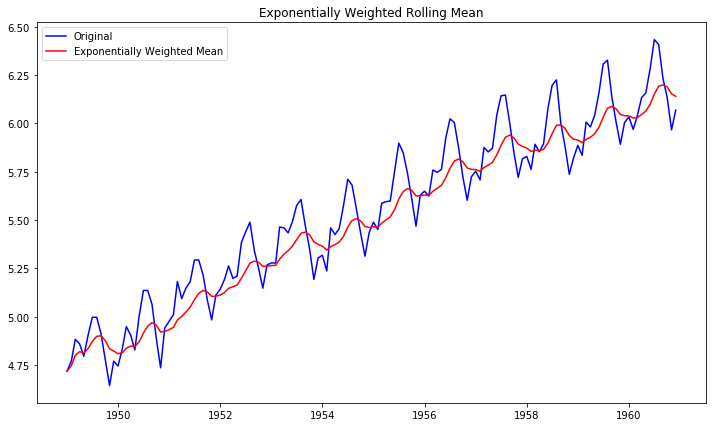

In [11]:
# Use Pandas ewma() to calculate Weighted Moving Average of ts_log
exp_rmean = np.log(ts).ewm(halflife=4).mean()
# Plot the original data with exp weighted average
fig = plt.figure(figsize=(12,7))
orig = plt.plot(np.log(ts), color='b', label='Original')
mean = plt.plot(exp_rmean, color='r', label='Exponentially Weighted Mean')
plt.legend(loc='best')
plt.title('Exponentially Weighted Rolling Mean')



In [12]:
# Subtract the moving average from the original data and plot
difference = np.log(ts) - exp_rmean



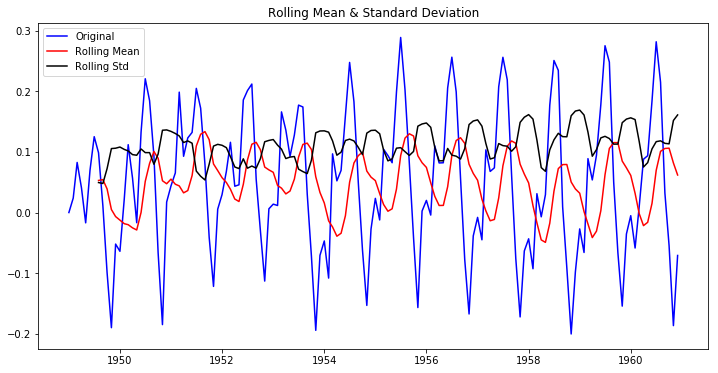

Results of Dickey-Fuller Test:
Test Statistic                  -3.297250
p-value                          0.015002
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [13]:
# do a stationarity check
stationarity_check(difference)

### Based on the visuals and on the Dickey-Fuller test, what do you conclude?


Series is stationary

## Differencing

Using exponentially weighted moving averages, we seem to have removed the upward trend, but not the seasonality issue. Now use differencing to remove seasonality. Make sure you use the right amount of `periods`. Start from the log-transformed, exponentially weighted rolling mean-subtracted series.

After you differenced the series, run the `stationarity check` again.

In [15]:
# difference your data and look at the head
data_diff = difference.diff(periods=12)
data_diff.head()

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN


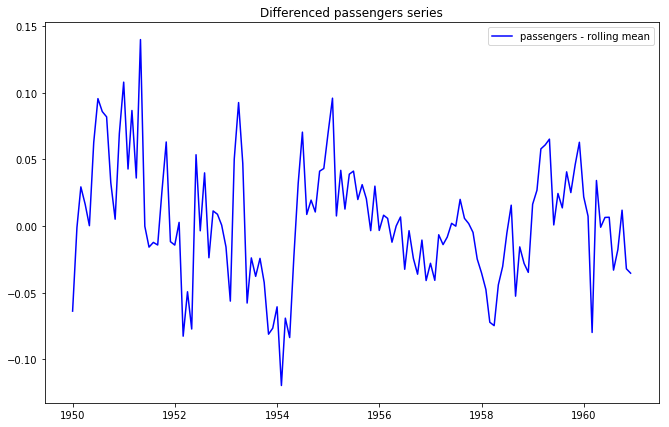

In [16]:
# plot your differenced time series
fig = plt.figure(figsize=(11,7))
plt.plot(data_diff, color='blue',label='passengers - rolling mean')
plt.legend(loc='best')
plt.title('Differenced passengers series')
plt.show(block=False)

In [17]:
# drop nans
data_diff.dropna(inplace=True)

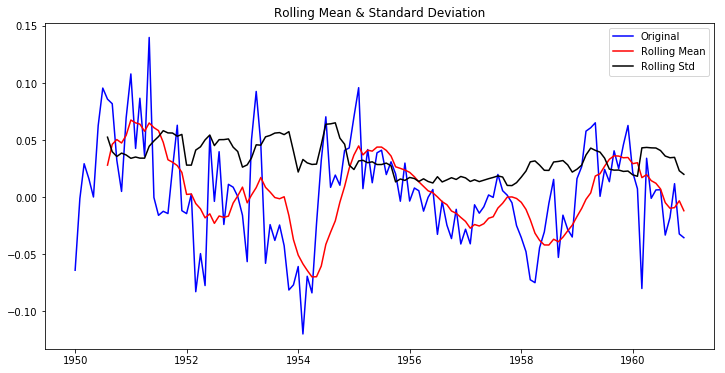

Results of Dickey-Fuller Test:
Test Statistic                  -3.601666
p-value                          0.005729
#Lags Used                      12.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [18]:
# perform the stationarity check
stationarity_check(data_diff)

### Your conclusion

Seasonality appears to be gone?

## Summary 

In this lab, you learned how to make time series stationary through using log transforms, rolling means and differencing.